# ColpoNet UV3: Custom Segmentation Network for Cervical Lesion Imaging

---

## Objective

Develop and train custom deep learning models for semantic segmentation of colposcopic images, aiming to precisely isolate analyzable regions and exclude non-relevant areas (e.g., instruments, background). The segmented masks will later be used to improve downstream detection and visualization of cervical lesions.

---

## Data Overview

- **Dataset:**  
  A large folder (~2000 images) of colposcopic images and segmentation masks.

- **Naming convention:**  
  - **Original image:** `filename.png`  
  - **Segmentation mask:** `filename-s.png`  
  (The mask has the exact name as the image, but with `-s` appended before the extension.)
  - *Note: Not all images have a corresponding mask. Some images may have multiple annotations (for lesion types), but for this stage we only consider the binary mask ending with `-s`.*

- **Goal:**  
  Filter and pair only images that have both the original and the corresponding mask. These pairs will be used for supervised segmentation model training.

---

## Notebook Structure

1. **Library Imports**
2. **Data Handling & Filtering**
3. **Dataset Preparation**
4. **Model Implementation (e.g., U-Net, DeepLabV3+)**
5. **Training & Validation**
6. **Evaluation & Visualization**
7. **Saving & Exporting Results**
8. **Integration with ColpoNet pipeline**

---

**Let’s begin by importing the required libraries.**


## 1. Library Imports

In [1]:
# General and Data Handling
import os
import glob
import random
import shutil
from tqdm import tqdm

# Numerical and Image Processing
import numpy as np
import pandas as pd
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt

# PyTorch & Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

# Segmentation Models (Install if needed: segmentation_models_pytorch)
try:
    import segmentation_models_pytorch as smp
except ImportError:
    print("segmentation_models_pytorch not found. Install with `pip install segmentation-models-pytorch`.")

# Optional: Albumentations for data augmentation
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
except ImportError:
    print("albumentations not found. Install with `pip install albumentations`.")

# Utility for progress bars
from tqdm.notebook import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")


## 2. Data Handling & Filtering 

In [2]:
import os

# Define base directory containing the data
base_dir = "img"
all_files = os.listdir(base_dir)

# Dictionaries to store paths by base filename
images = {}
masks = {}

# Loop through all files and classify as image or mask
for file in all_files:
    name, ext = os.path.splitext(file)
    ext = ext.lower()
    if ext in [".jpg", ".jpeg", ".png"]:
        images[name] = os.path.join(base_dir, file)
    elif ext in [".tif", ".tiff", ".png"]:
        masks[name] = os.path.join(base_dir, file)

# Pair images and masks with the same base name
paired_data = []
for name in images:
    if name in masks:
        paired_data.append((images[name], masks[name]))

# Display results
print("=== Pairing Results ===")
print(f"Total image files found: {len(images)}")
print(f"Total mask files found: {len(masks)}")
print(f"Total valid pairs: {len(paired_data)}")

# Show a sample pair
if paired_data:
    print("\nSample pair:")
    print(f"Image : {paired_data[0][0]}")
    print(f"Mask  : {paired_data[0][1]}")
else:
    print("⚠️ No valid pairs found.")


=== Pairing Results ===
Total image files found: 931
Total mask files found: 964
Total valid pairs: 448

Sample pair:
Image : img/102.jpg
Mask  : img/102.tif


## 3.Dataset Preparation

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import torch

# Transformaciones: redimensionar, convertir a tensor, normalizar
image_size = (256, 256)

image_transform = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),  # convierte a [0, 1], normaliza canales automáticamente
])

mask_transform = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),  # convierte a tensor de 1 canal
    T.Lambda(lambda x: (x > 0).float())  # binariza la máscara
])

class ColpoSegmentationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        # Abrir imagen y máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # escala de grises

        # Aplicar transformaciones
        image = image_transform(image)
        mask = mask_transform(mask)

        return image, mask


In [4]:
from torch.utils.data import DataLoader

# Crear dataset
dataset = ColpoSegmentationDataset(paired_data)

# Crear loader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Ejemplo: obtener un batch
for images, masks in dataloader:
    print("Imagenes:", images.shape)  # [8, 3, 256, 256]
    print("Máscaras:", masks.shape)   # [8, 1, 256, 256]
    break


Imagenes: torch.Size([8, 3, 256, 256])
Máscaras: torch.Size([8, 1, 256, 256])


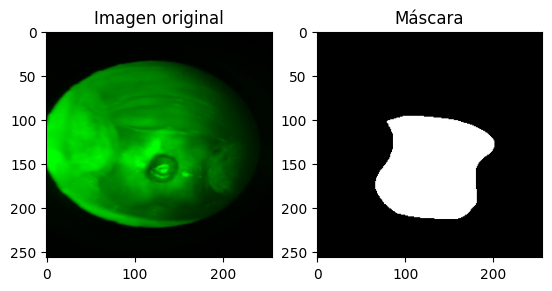

In [5]:
import matplotlib.pyplot as plt

# Mostrar 4 pares de imagen/máscara
for images, masks in dataloader:
    for i in range(1):
        img = images[i].permute(1, 2, 0).numpy()  # de [C, H, W] a [H, W, C]
        msk = masks[i][0].numpy()                # tomar canal único

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img)
        ax[0].set_title("Imagen original")
        ax[1].imshow(msk, cmap="gray")
        ax[1].set_title("Máscara")
        plt.show()
    break


## 4. Model Implementation

### 4.1 UNET

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Encoder
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(self.double_conv(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.double_conv(features[-1], features[-1]*2)

        # Decoder
        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.up_convs.append(
                self.double_conv(feature*2, feature)
            )

        # Final output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.ups)):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])  # Asegura match

            x = torch.cat((skip_connection, x), dim=1)
            x = self.up_convs[idx](x)

        return torch.sigmoid(self.final_conv(x))

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


In [7]:
model = UNet(in_channels=3, out_channels=1)
x = torch.randn((1, 3, 256, 256))  # batch de prueba
y = model(x)
print(y.shape)  #

torch.Size([1, 1, 256, 256])


In [8]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn

class DeepLabV3Binary(nn.Module):
    def __init__(self, pretrained=False):
        super(DeepLabV3Binary, self).__init__()
        self.model = deeplabv3_resnet50(pretrained=pretrained)
        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # 1 clase
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)['out']  # salida cruda
        x = self.activation(x)    # binaria [0,1]
        return x


In [9]:
model = DeepLabV3Binary(pretrained=False)
model.eval()  # ⚠️ Importante
x = torch.randn((1, 3, 256, 256))
y = model(x)
print(y.shape)



torch.Size([1, 1, 256, 256])


In [10]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


In [11]:
class ColpoNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ColpoNet, self).__init__()

        # Encoder
        self.conv1_1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2_1 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3_1 = ConvBlock(128, 256)

        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2_2 = ConvBlock(128 + 128, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1_2 = ConvBlock(64 + 64, 64)

        # Output
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1_1 = self.conv1_1(x)                     # [B, 64, 256, 256]
        x2_1 = self.conv2_1(self.pool1(x1_1))      # [B, 128, 128, 128]
        x3_1 = self.conv3_1(self.pool2(x2_1))      # [B, 256, 64, 64]

        # Decoder (Nested)
        x2_2 = self.conv2_2(torch.cat([x2_1, self.up2(x3_1)], dim=1))  # [B, 128+128, 128,128]
        x1_2 = self.conv1_2(torch.cat([x1_1, self.up1(x2_2)], dim=1))  # [B, 64+64, 256,256]

        out = torch.sigmoid(self.out_conv(x1_2))   # [B, 1, 256, 256]
        return out


In [12]:
model = ColpoNet()
x = torch.randn((1, 3, 256, 256))
y = model(x)
print(y.shape)  # torch.Size([1, 1, 256, 256])


torch.Size([1, 1, 256, 256])


## 5. Training & Validation

In [13]:
import torch
import torch.nn.functional as F

# Dice Coefficient
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# IoU (Jaccard Index)
def iou_score(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# Combined Dice + BCE Loss
class DiceBCELoss(torch.nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = torch.nn.BCELoss()

    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = 1 - dice_coef(pred, target)
        return bce + dice


In [14]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, masks)

            preds_bin = (preds > 0.5).float()
            total_loss += loss.item()
            total_iou += iou_score(preds_bin, masks)
            total_dice += dice_coef(preds_bin, masks)

    return {
        "val_loss": total_loss / len(dataloader),
        "val_iou": total_iou / len(dataloader),
        "val_dice": total_dice / len(dataloader),
    }


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import sys

def train_model(model, train_loader, val_loader, model_name="unet", epochs=30, device="cuda"):
    # Bloqueo absoluto: solo permite GPU
    if device == "cuda" and not torch.cuda.is_available():
        print("🚫 ERROR: No se encontró GPU CUDA. Este modelo solo puede entrenarse en GPU (CUDA).")
        sys.exit(1)
    elif device != "cuda":
        print("🚫 ERROR: Este modelo está configurado solo para GPU (CUDA). No se permite entrenamiento en CPU.")
        sys.exit(1)

    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            inputs, masks = batch
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validación (opcional, puede ajustar según tu implementación)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, masks = batch
                inputs = inputs.to(device)
                masks = masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Guardar el modelo (puedes adaptar la ruta y formato)
    torch.save(model.state_dict(), f"{model_name}_final.pth")
    print("✅ Entrenamiento finalizado y modelo guardado.")




In [16]:
# Suponiendo que ya tienes tu DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

# Cambia aquí entre "unet", "deeplab", "colponet"
model_name = "deeplab"
model = DeepLabV3Binary()  # o UNet(), o ColpoNet()

from sklearn.model_selection import train_test_split

train_pairs, val_pairs = train_test_split(paired_data, test_size=0.2, random_state=42)
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Dataset personalizado
class ColpoSegmentationDataset(Dataset):
    def __init__(self, pairs, transform_img=None, transform_mask=None):
        self.pairs = pairs
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

# Transformaciones
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Datasets
train_dataset = ColpoSegmentationDataset(train_pairs, transform_img, transform_mask)
val_dataset   = ColpoSegmentationDataset(val_pairs, transform_img, transform_mask)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)


## 6. Evaluation & Visualization

In [17]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, model_path, device="cuda", num_samples=5):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    imgs_shown = 0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            preds_bin = (preds > 0.5).float()

            for i in range(imgs.size(0)):
                if imgs_shown >= num_samples:
                    return
                img = imgs[i].cpu().permute(1, 2, 0)
                mask = masks[i].cpu().squeeze()
                pred = preds_bin[i].cpu().squeeze()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img)
                axs[0].set_title("Imagen original")
                axs[0].axis('off')

                axs[1].imshow(mask, cmap='gray')
                axs[1].set_title("Máscara real")
                axs[1].axis('off')

                axs[2].imshow(pred, cmap='gray')
                axs[2].set_title("Predicción")
                axs[2].axis('off')

                plt.tight_layout()
                plt.show()

                imgs_shown += 1


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import sys

def train_model(model, train_loader, val_loader, model_name="unet", epochs=30, device="cuda"):
    # Verifica que la instalación de PyTorch tiene CUDA compilado
    if not torch.cuda.is_available() or not torch.backends.cudnn.is_available():
        print("🚫 ERROR: PyTorch no fue compilado con soporte CUDA o no hay GPU disponible.")
        sys.exit(1)
    if device != "cuda":
        print("🚫 ERROR: Solo se permite entrenamiento en GPU (CUDA).")
        sys.exit(1)

    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            inputs, masks = batch
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, masks = batch
                inputs = inputs.to(device)
                masks = masks.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    torch.save(model.state_dict(), f"{model_name}_final.pth")
    print("✅ Entrenamiento finalizado y modelo guardado.")



In [21]:
model = UNet()  # o ColpoNet(), o DeepLabV3Binary()
model_name = "unet"  # o "colponet", "deeplab"

train_model(model, train_loader, val_loader, model_name=model_name, epochs=30, device="cuda")


🚫 ERROR: PyTorch no fue compilado con soporte CUDA o no hay GPU disponible.


SystemExit: 1

## 7.Saving & Exporting Results

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'Loss': loss.item()})

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")


In [ ]:
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    iou_total, dice_total, n = 0, 0, 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = (outputs > threshold).float()

            intersection = (preds * masks).sum((1, 2, 3))
            union = (preds + masks).sum((1, 2, 3)) - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            dice = (2 * intersection + 1e-6) / (preds.sum((1, 2, 3)) + masks.sum((1, 2, 3)) + 1e-6)

            iou_total += iou.sum().item()
            dice_total += dice.sum().item()
            n += images.size(0)

    avg_iou = iou_total / n
    avg_dice = dice_total / n
    print(f"Evaluación: IoU = {avg_iou:.4f}, DICE = {avg_dice:.4f}")
    return avg_iou, avg_dice


In [ ]:
# Definir criterios y optimizadores
criterion = nn.BCELoss()

results = {}

for name, model_class in {
    'UNet': ColpoUNet,
    'DeepLabV3': DeepLabV3,
    'ColpoNet': ColpoNet
}.items():
    print(f"\n=== Entrenando modelo: {name} ===")
    model = model_class()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_model(model, dataloader, criterion, optimizer, num_epochs=10)
    iou, dice = evaluate_model(model, dataloader)

    results[name] = {'model': model, 'iou': iou, 'dice': dice}


In [ ]:
best_model = max(results.items(), key=lambda x: x[1]['iou'])
print(f"\n✅ Mejor modelo: {best_model[0]}")
print(f"IoU: {best_model[1]['iou']:.4f} | DICE: {best_model[1]['dice']:.4f}")
